In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

$$g_j = e^{jpx} cos (2\pi j qx) $$

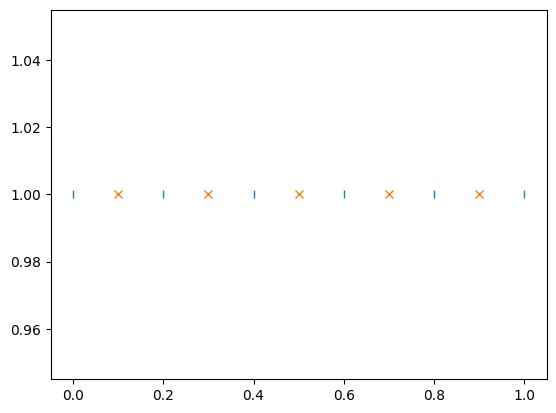

In [10]:
M = 5
x_node = np.linspace(0, 1, M+1)
x_center = (x_node[:-1] + x_node[1:]) * 0.5
plt.plot(x_node, np.ones(M+1), '|')
plt.plot(x_center, np.ones(M), 'x')

In [11]:
M = 5
N = 30
p = -0.05
q = 0.1
j = 0
g_j = np.exp(j*p*x_node) * np.cos(2*np.pi*q*j*x_node)

In [12]:
data = np.ones((2, M+1))*0.5
data

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

In [19]:
M = 100
N = 30
p = -0.05
q = 0.1
x_node = np.linspace(0, 1, M+1)
x_center = (x_node[1:] + x_node[:-1]) * 0.5
G_node = np.zeros((M+1, N))
for j in range(0, N):
    G_node[:,j] = np.exp(j*p*x_node) * np.cos(2*np.pi*q*j*x_node)
dx = np.diff(x_node)    
Av = sp.spdiags(np.ones((2, M+1))*0.5, [0, 1], M, M+1)
dx_diag = sp.spdiags(dx, [0], M, M)
G = G_node.T @ Av.T @  dx_diag 

In [36]:
def get_G_matrix(M, N, p, q):
    """
    Comments
    """
    x_node = np.linspace(0, 1, M+1)
    x_center = (x_node[1:] + x_node[:-1]) * 0.5
    G_node = np.zeros((M+1, N))
    for j in range(0, N):
        G_node[:,j] = np.exp(j*p*x_node) * np.cos(2*np.pi*q*j*x_node)
    dx = np.diff(x_node)    
    Av = sp.spdiags(np.ones((2, M+1))*0.5, [0, 1], M, M+1)
    dx_diag = sp.spdiags(dx, [0], M, M)
    G = G_node.T @ Av.T @  dx_diag     
    return G, x_center

In [66]:
M = 100
N = 30
p = -0.05
q = 0.1
G, x_center = get_G_matrix(M, N, p, q)

In [67]:
m = np.zeros(M)

In [70]:
box_index = np.logical_and(x_center>0.2, x_center<0.4)
m[box_index] = 1.

In [74]:
dpred = G @ m 

(1.0, 30.0)

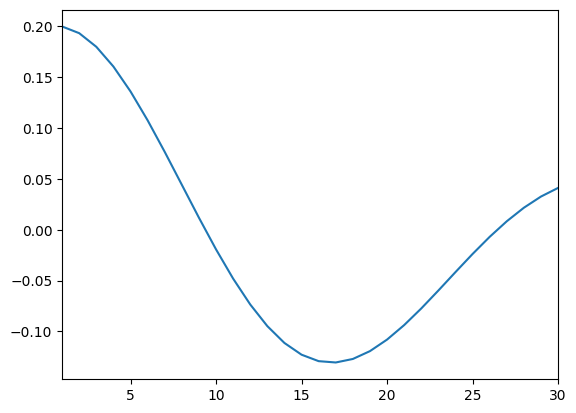

In [76]:
plt.plot(np.arange(N)+1, dpred)
plt.xlim(1, N)

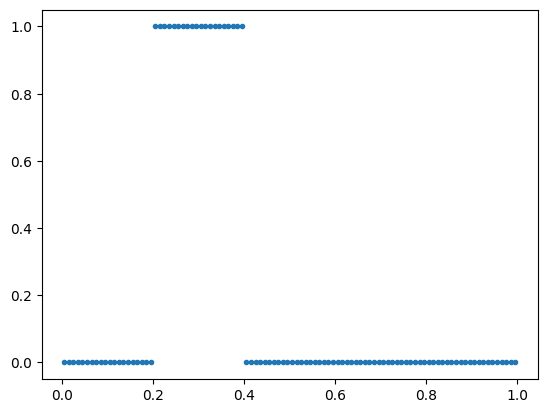

In [73]:
plt.plot(x_center, m, '.')

In [59]:
# i_column = 30
# out = plt.plot(x_center, G.T[:,:i_column])

In [40]:
G.shape

(30, 100)

In [20]:
e = np.ones((20, 10))

In [30]:
vec = np.arange(10)
vec

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

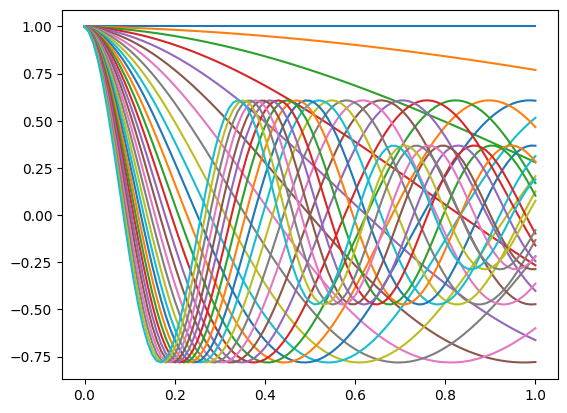

In [33]:
plt.plot(x_node, G_node.T)

# Let's invert

In [91]:
dpred = G@m
dobs = dpred.copy()

In [92]:
m_est = np.linalg.solve(G.T @ G, G.T @ dpred)

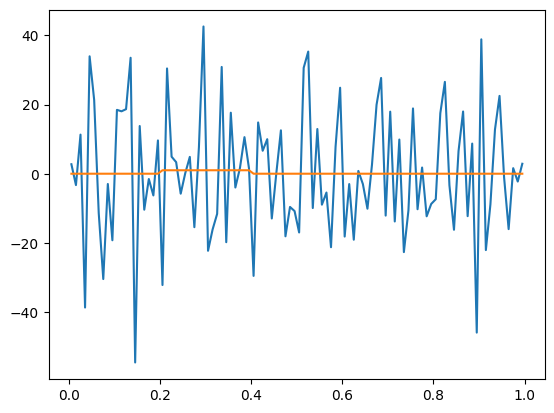

In [94]:
plt.plot(x_center, m_est)
plt.plot(x_center, m)

## It does not work just with the data

## Let's add a regularization term

In [95]:
phi_m = np.linalg.n  rm(m)**2

In [96]:
I = sp.spdiags(np.ones(M), [0], M, M)

In [107]:
beta = 0.01

In [108]:
m_est_reg = np.linalg.solve(G.T @ G + beta*I , G.T @ dpred)

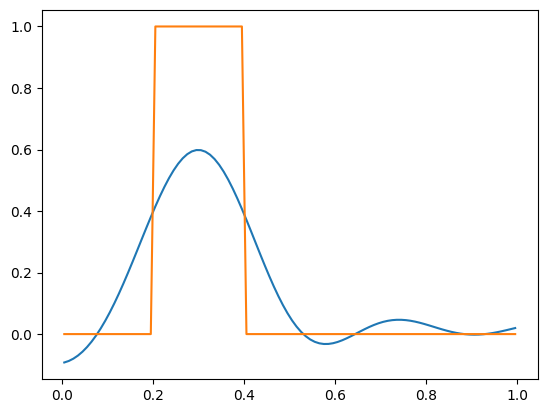

In [109]:
plt.plot(x_center, m_est_reg)
plt.plot(x_center, m)